In [1]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.132 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)


In [2]:
!pip install pyspellchecker
from spellchecker import SpellChecker

spell = SpellChecker()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 20.4 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
# from spellchecker import SpellChecker


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from ultralytics import YOLO

text_dec_model_path = 'drive/MyDrive/Study/AIO/Scene Text Recognition/models/yolov8/detec/train/weights/best.pt'
yolo = YOLO(text_dec_model_path)

In [6]:
class CRNN(nn.Module):
  def __init__(
      self,
      vocab_size,
      hidden_size,
      n_layers,
      dropout= 0.2,
      unfreeze_layers = 3
  ):
    super(CRNN,self).__init__()

    backbone = timm.create_model(
        'resnet152',
        in_chans =1,
        pretrained = True
    )
    modules = list(backbone.children())[:-2]
    modules.append(nn.AdaptiveAvgPool2d((1,None)))
    self.backbone = nn.Sequential(*modules)

    #unfreeze the last few layers
    for parameter in self.backbone[-unfreeze_layers:].parameters():
      parameter.requires_grad = True

    self.mapSeq = nn.Sequential(
        nn.Linear(2048,512),
        # nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),
    )

    # self.lstm = nn.LSTM(
    #     512,hidden_size,
    #     n_layers,bidirectional = True, batch_first = True,
    #     dropout = dropout if n_layers > 1 else 0
    # )
    self.gru = nn.GRU(
      512,
      hidden_size,
      n_layers,
      bidirectional = True,
      batch_first = True,
      dropout = dropout if n_layers > 1 else 0
    )

    self.layer_norm = nn.LayerNorm(hidden_size*2)

    self.out = nn.Sequential(
        nn.Linear(hidden_size*2,vocab_size),
        nn.LogSoftmax(dim=2)
    )

  def forward(self,x):
    # print(x.shape)

    x = self.backbone(x)
    # print(x.shape)

    x= x.permute(0,3,1,2)
    # print(x.shape)

    x = x.view(x.size(0),x.size(1),-1)
    # print(x.shape)

    x= self.mapSeq(x)
    # print(x.shape)

    x, _ = self.gru(x)
    # print(x.shape)

    x = self.layer_norm(x)
    # print(x.shape)

    x = self.out(x)
    x =x.permute(1,0,2)

    return x

In [7]:
chars= "0123456789abcdefghijklmnopqrstuvwxyz-"
Vocab_size = len(chars)

char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [8]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "drive/MyDrive/Study/AIO/Scene Text Recognition/models/ocr_crnn_base_best_final.pt"
crnn_model = CRNN(
    vocab_size = Vocab_size,
    hidden_size= hidden_size,
    n_layers = n_layers,
    dropout = dropout_prob,
    unfreeze_layers = unfreeze_layers
).to(device)

crnn_model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

<All keys matched successfully>

In [9]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]
    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()

    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
        text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences


In [10]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, edgecolor='red', linewidth=2
            )
        )
        plt.text(
            x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.show()


In [11]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device):
    # Detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load the image
    img = Image.open(img_path)

    predictions = []

    # Iterate through the results
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox
        confidence = conf
        detected_class = cls
        name = names[int(cls)]

        # Extract the detected object and crop it
        cropped_image = img.crop((x1, y1, x2, y2))

        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )
        word = transcribed_text[0]

        correction = spell.correction(word)

        if correction is None:
          correction = word
        predictions.append((bbox, name, confidence, correction))

    visualize_detections(img, predictions)

    return predictions


In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,
        ),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear = 1),
        transforms.RandomPerspective(distortion_scale=0.5,p=0.5,interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((100,420)),
        # transforms.Resize((640,640)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),
        ]),
}

In [13]:
# img_dir = 'drive/MyDrive/Study/AIO/Scene Text Recognition/SceneTrialTrain/apanar_06.08.2002'

inf_transforms = data_transforms['val']

# for img_filename in os.listdir(img_dir):
#     img_path = os.path.join(img_dir, img_filename)
#     predictions = predict(
#         img_path,
#         data_transforms=inf_transforms,
#         text_det_model=yolo,
#         text_reg_model=crnn_model,
#         idx_to_char=idx_to_char,
#         device=device
#     )

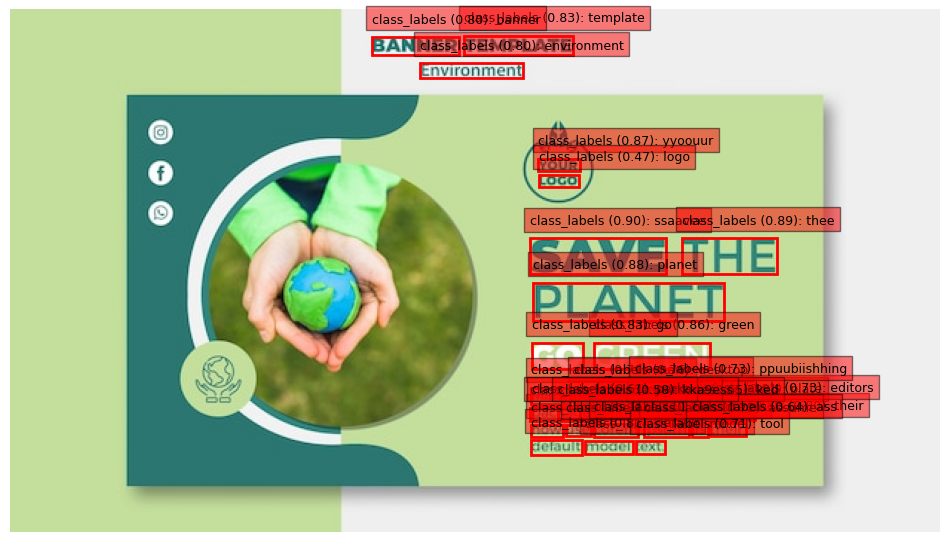

In [15]:
import requests
import cv2
import json
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Tải ảnh từ URL
url = 'https://img.freepik.com/free-psd/environment-banner-template-mock-up_23-2148414723.jpg'
img_data = requests.get(url).content

# Lưu ảnh vào file cục bộ
with open('image.jpg', 'wb') as f:
    f.write(img_data)

# Đọc ảnh từ file cục bộ
img_path = 'image.jpg'

# Dự đoán
predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        text_det_model=yolo,
        text_reg_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device
    )
